In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import sys
sys.path.append("../")
from aif360.algorithms.inprocessing.gerryfair_classifier import *
from aif360.algorithms.inprocessing.gerryfair.clean import *
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import *
from aif360.algorithms.inprocessing.gerryfair.auditor import *
from sklearn import svm
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
from IPython.display import IFrame
matplotlib.use('Agg')





### Basics: `Model()`, `fit()`, `predict(), audit()`
We first demonstrate how to instantiate a `Model`, `fit` it with respect to rich subgroup fairness, and `predict` the label of a new example. We remark that when we set the `print_flag = True` at each iteration of the algorithm we print the error, fairness violation, and violated group size of most recent model. The error is the classification error of the classifier. At each round the Learner tries to find a classifier that minimizes the classification error plus a weighted sum of the fairness disparities on all the groups that the Auditor has found up until that point. By contrast the Auditor tries to find the group at each round with the greatest rich subgroup disparity with respect to the Learner's model. We define `violated group size` as the size (as a fraction of the dataset size) of this group, and the `fairness violation` as the `violated group size` times the difference in the statistical rate (FP or FN rate) on the group vs. the whole population. 

In the example below we set `max_iterations=5000` which is in-line with time to convergence observed in [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166), but advise that this can be highly dataset dependent. Our target $\gamma$-disparity is `gamma = .001`, our statistical rate is false positive rate or `FP`, and our weighted regression oracle is linear regression. We observe that the unconstrained (with no fairness constraint) classifier has error $.185$ and $\gamma$-disparity $.022$. After $5000$ iterations we obtain a classifier that $\gamma$-fair, and has error $.230$. We note that we converge to a fair, and almost as accurate classifier after just a hundred iterations.


In [3]:
C = 10
print_flag = True
gamma = .008
max_iterations = 5000

fair_model = Model(C=C, printflag=print_flag, gamma=gamma, fairness_def='FP',
             max_iters=max_iterations, heatmapflag=False, heatmap_iter=max_iterations, heatmap_path='heatmap')
# balance flag artificially ensures mean(y) = .5
data_set = load_preproc_data_adult(sub_samp=200, balance=True)

# fit method
communities_all_errors, communities_violations = fair_model.fit(data_set,
                                                 early_termination=True, return_values=True)
# predict method
dataset_yhat = fair_model.predict(data_set)



iteration: 1, error: 0.24, fairness violation: 0.02255, violated group size: 0.185
iteration: 2, error: 0.29, fairness violation: 0.014975, violated group size: 0.185
iteration: 3, error: 0.3066666666666667, fairness violation: 0.012450000000000001, violated group size: 0.185
iteration: 4, error: 0.315, fairness violation: 0.0111875, violated group size: 0.315
iteration: 5, error: 0.31999999999999995, fairness violation: 0.010430000000000002, violated group size: 0.315
iteration: 6, error: 0.3183333333333333, fairness violation: 0.011041666666666668, violated group size: 0.225
iteration: 7, error: 0.32214285714285706, fairness violation: 0.010750000000000001, violated group size: 0.225
iteration: 8, error: 0.324375, fairness violation: 0.01053125, violated group size: 0.225
iteration: 9, error: 0.32611111111111113, fairness violation: 0.010361111111111118, violated group size: 0.275
iteration: 10, error: 0.32800000000000007, fairness violation: 0.010225, violated group size: 0.225
iter

iteration: 77, error: 0.35974025974025975, fairness violation: 0.00828246753246753, violated group size: 0.225
iteration: 78, error: 0.3602564102564103, fairness violation: 0.008233974358974357, violated group size: 0.225
iteration: 79, error: 0.3600632911392405, fairness violation: 0.008243670886075947, violated group size: 0.225
iteration: 80, error: 0.35987500000000006, fairness violation: 0.008253124999999998, violated group size: 0.225
iteration: 81, error: 0.3596913580246914, fairness violation: 0.008262345679012344, violated group size: 0.225
iteration: 82, error: 0.3594512195121952, fairness violation: 0.008271341463414633, violated group size: 0.225
iteration: 83, error: 0.3592168674698795, fairness violation: 0.00828012048192771, violated group size: 0.225
iteration: 84, error: 0.35970238095238094, fairness violation: 0.008235119047619045, violated group size: 0.225
iteration: 85, error: 0.35952941176470593, fairness violation: 0.00824411764705882, violated group size: 0.225


iteration: 152, error: 0.3581578947368421, fairness violation: 0.008192434210526314, violated group size: 0.225
iteration: 153, error: 0.35807189542483664, fairness violation: 0.008197712418300652, violated group size: 0.225
iteration: 154, error: 0.358409090909091, fairness violation: 0.008173701298701297, violated group size: 0.225
iteration: 155, error: 0.35832258064516126, fairness violation: 0.008179032258064515, violated group size: 0.275
iteration: 156, error: 0.3582371794871795, fairness violation: 0.00818429487179487, violated group size: 0.225
iteration: 157, error: 0.3581528662420383, fairness violation: 0.008189490445859872, violated group size: 0.225
iteration: 158, error: 0.3580696202531646, fairness violation: 0.008194620253164555, violated group size: 0.225
iteration: 159, error: 0.3578301886792453, fairness violation: 0.008227987421383648, violated group size: 0.275
iteration: 160, error: 0.35775000000000007, fairness violation: 0.008232812499999999, violated group siz

iteration: 226, error: 0.35814159292035397, fairness violation: 0.008217920353982298, violated group size: 0.225
iteration: 227, error: 0.35808370044052873, fairness violation: 0.008221365638766517, violated group size: 0.275
iteration: 228, error: 0.3579605263157895, fairness violation: 0.008224780701754383, violated group size: 0.225
iteration: 229, error: 0.35788209606986904, fairness violation: 0.008228165938864624, violated group size: 0.225
iteration: 230, error: 0.35782608695652185, fairness violation: 0.008231521739130433, violated group size: 0.275
iteration: 231, error: 0.3577705627705628, fairness violation: 0.008234848484848484, violated group size: 0.225
iteration: 232, error: 0.35771551724137934, fairness violation: 0.008238146551724133, violated group size: 0.225
iteration: 233, error: 0.35766094420600864, fairness violation: 0.008241416309012872, violated group size: 0.275
iteration: 234, error: 0.3576068376068377, fairness violation: 0.008244658119658115, violated grou

iteration: 300, error: 0.35851666666666676, fairness violation: 0.008125833333333336, violated group size: 0.275
iteration: 301, error: 0.358687707641196, fairness violation: 0.008113787375415283, violated group size: 0.225
iteration: 302, error: 0.3586423841059603, fairness violation: 0.008116721854304636, violated group size: 0.275
iteration: 303, error: 0.35881188118811885, fairness violation: 0.008104785478547856, violated group size: 0.225
iteration: 304, error: 0.3589802631578948, fairness violation: 0.008092927631578949, violated group size: 0.225
iteration: 305, error: 0.3590983606557378, fairness violation: 0.008081147540983605, violated group size: 0.275
iteration: 306, error: 0.3590522875816993, fairness violation: 0.008084150326797386, violated group size: 0.275
iteration: 307, error: 0.3590065146579804, fairness violation: 0.008087133550488599, violated group size: 0.225
iteration: 308, error: 0.3590097402597403, fairness violation: 0.0080900974025974, violated group size:

iteration: 375, error: 0.35997333333333337, fairness violation: 0.008036666666666668, violated group size: 0.275
iteration: 376, error: 0.35993351063829787, fairness violation: 0.008039228723404256, violated group size: 0.275
iteration: 377, error: 0.3598938992042441, fairness violation: 0.008041777188328915, violated group size: 0.275
iteration: 378, error: 0.3598544973544975, fairness violation: 0.008044312169312168, violated group size: 0.275
iteration: 379, error: 0.35980211081794194, fairness violation: 0.008046833773087072, violated group size: 0.275
iteration: 380, error: 0.3597631578947369, fairness violation: 0.00804934210526316, violated group size: 0.275
iteration: 381, error: 0.35972440944881895, fairness violation: 0.008051837270341205, violated group size: 0.225
iteration: 382, error: 0.35968586387434565, fairness violation: 0.008054319371727748, violated group size: 0.225
iteration: 383, error: 0.35964751958224545, fairness violation: 0.008056788511749347, violated group

iteration: 449, error: 0.3586636971046771, fairness violation: 0.0081152561247216, violated group size: 0.225
iteration: 450, error: 0.3586333333333333, fairness violation: 0.00811722222222222, violated group size: 0.275
iteration: 451, error: 0.35860310421286035, fairness violation: 0.008119179600886916, violated group size: 0.225
iteration: 452, error: 0.3585730088495576, fairness violation: 0.00812112831858407, violated group size: 0.225
iteration: 453, error: 0.3585430463576159, fairness violation: 0.00812306843267108, violated group size: 0.275
iteration: 454, error: 0.3584691629955947, fairness violation: 0.008134911894273126, violated group size: 0.275
iteration: 455, error: 0.35858241758241766, fairness violation: 0.008126923076923073, violated group size: 0.225
iteration: 456, error: 0.358530701754386, fairness violation: 0.008128837719298244, violated group size: 0.225
iteration: 457, error: 0.3584901531728666, fairness violation: 0.008130743982494531, violated group size: 0.

iteration: 523, error: 0.35841300191204595, fairness violation: 0.008145793499043971, violated group size: 0.225
iteration: 524, error: 0.3583874045801528, fairness violation: 0.008147423664122131, violated group size: 0.225
iteration: 525, error: 0.35851428571428584, fairness violation: 0.008140476190476186, violated group size: 0.225
iteration: 526, error: 0.3586121673003803, fairness violation: 0.008133555133079846, violated group size: 0.275
iteration: 527, error: 0.3585483870967743, fairness violation: 0.008143738140417453, violated group size: 0.275
iteration: 528, error: 0.3585227272727273, fairness violation: 0.008145359848484844, violated group size: 0.225
iteration: 529, error: 0.3584688090737241, fairness violation: 0.008146975425330808, violated group size: 0.225
iteration: 530, error: 0.3584245283018868, fairness violation: 0.008148584905660375, violated group size: 0.275
iteration: 531, error: 0.3583992467043315, fairness violation: 0.008150188323917134, violated group si

iteration: 596, error: 0.35838087248322154, fairness violation: 0.00815226510067114, violated group size: 0.275
iteration: 597, error: 0.35835845896147417, fairness violation: 0.0081536850921273, violated group size: 0.275
iteration: 598, error: 0.35832775919732457, fairness violation: 0.008155100334448157, violated group size: 0.275
iteration: 599, error: 0.3584140233722872, fairness violation: 0.008148998330550918, violated group size: 0.275
iteration: 600, error: 0.35839166666666666, fairness violation: 0.008150416666666662, violated group size: 0.225
iteration: 601, error: 0.35847753743760413, fairness violation: 0.008144342762063224, violated group size: 0.225
iteration: 602, error: 0.35856312292358816, fairness violation: 0.008138289036544845, violated group size: 0.225
iteration: 603, error: 0.35864842454394696, fairness violation: 0.008132255389718073, violated group size: 0.275
iteration: 604, error: 0.35861754966887427, fairness violation: 0.00813369205298013, violated group 

iteration: 670, error: 0.3587014925373135, fairness violation: 0.008125, violated group size: 0.275
iteration: 671, error: 0.35868107302533536, fairness violation: 0.008126304023845001, violated group size: 0.225
iteration: 672, error: 0.3586607142857144, fairness violation: 0.008127604166666663, violated group size: 0.225
iteration: 673, error: 0.358736998514116, fairness violation: 0.008122213967310546, violated group size: 0.275
iteration: 674, error: 0.3587166172106826, fairness violation: 0.008123516320474774, violated group size: 0.225
iteration: 675, error: 0.3586814814814816, fairness violation: 0.008124814814814814, violated group size: 0.275
iteration: 676, error: 0.35866124260355037, fairness violation: 0.008126109467455622, violated group size: 0.275
iteration: 677, error: 0.3586410635155097, fairness violation: 0.00812740029542097, violated group size: 0.275
iteration: 678, error: 0.35861356932153404, fairness violation: 0.008128687315634216, violated group size: 0.225
ite

iteration: 745, error: 0.3591610738255034, fairness violation: 0.008092281879194628, violated group size: 0.225
iteration: 746, error: 0.3592493297587132, fairness violation: 0.008087466487935657, violated group size: 0.275
iteration: 747, error: 0.35923025435073624, fairness violation: 0.00808868808567604, violated group size: 0.275
iteration: 748, error: 0.35919117647058835, fairness violation: 0.008089906417112299, violated group size: 0.225
iteration: 749, error: 0.35917222963951945, fairness violation: 0.008091121495327102, violated group size: 0.275
iteration: 750, error: 0.3592333333333334, fairness violation: 0.00808633333333333, violated group size: 0.225
iteration: 751, error: 0.3593009320905459, fairness violation: 0.008081557922769638, violated group size: 0.225
iteration: 752, error: 0.3592819148936171, fairness violation: 0.008082779255319148, violated group size: 0.275
iteration: 753, error: 0.3592629482071713, fairness violation: 0.008083997343957502, violated group siz

iteration: 820, error: 0.3590914634146341, fairness violation: 0.008098475609756097, violated group size: 0.225
iteration: 821, error: 0.3590742996345919, fairness violation: 0.008099573690621196, violated group size: 0.275
iteration: 822, error: 0.3590571776155718, fairness violation: 0.008100669099756694, violated group size: 0.275
iteration: 823, error: 0.3590400972053463, fairness violation: 0.008101761846901579, violated group size: 0.225
iteration: 824, error: 0.358998786407767, fairness violation: 0.008108313106796118, violated group size: 0.275
iteration: 825, error: 0.3589636363636364, fairness violation: 0.008109393939393942, violated group size: 0.275
iteration: 826, error: 0.35901331719128327, fairness violation: 0.008105024213075062, violated group size: 0.225
iteration: 827, error: 0.3589963724304716, fairness violation: 0.008106106408706166, violated group size: 0.225
iteration: 828, error: 0.3590579710144927, fairness violation: 0.00810175120772947, violated group size:

iteration: 895, error: 0.35873743016759774, fairness violation: 0.00812374301675978, violated group size: 0.275
iteration: 896, error: 0.35878348214285716, fairness violation: 0.008119698660714287, violated group size: 0.225
iteration: 897, error: 0.3588405797101448, fairness violation: 0.008115663322185064, violated group size: 0.225
iteration: 898, error: 0.3588251670378619, fairness violation: 0.008116648106904234, violated group size: 0.275
iteration: 899, error: 0.35888209121245823, fairness violation: 0.008112625139043383, violated group size: 0.225
iteration: 900, error: 0.3589333333333333, fairness violation: 0.008108611111111117, violated group size: 0.275
iteration: 901, error: 0.3589178690344062, fairness violation: 0.008109600443951167, violated group size: 0.225
iteration: 902, error: 0.35890243902439023, fairness violation: 0.008110587583148558, violated group size: 0.225
iteration: 903, error: 0.35888704318936876, fairness violation: 0.008111572535991143, violated group 

iteration: 969, error: 0.35928276573787415, fairness violation: 0.008079205366357069, violated group size: 0.225
iteration: 970, error: 0.35925257731958765, fairness violation: 0.008080154639175259, violated group size: 0.275
iteration: 971, error: 0.35930484037075183, fairness violation: 0.008076467559217303, violated group size: 0.225
iteration: 972, error: 0.3593569958847737, fairness violation: 0.008072788065843621, violated group size: 0.225
iteration: 973, error: 0.35934224049331964, fairness violation: 0.008073741007194244, violated group size: 0.225
iteration: 974, error: 0.3593275154004107, fairness violation: 0.008074691991786448, violated group size: 0.225
iteration: 975, error: 0.3592923076923077, fairness violation: 0.008080256410256411, violated group size: 0.275
iteration: 976, error: 0.35927766393442623, fairness violation: 0.008081198770491802, violated group size: 0.275
iteration: 977, error: 0.35932958034800405, fairness violation: 0.008077533265097237, violated grou

iteration: 1043, error: 0.3592569511025887, fairness violation: 0.00807981783317354, violated group size: 0.275
iteration: 1044, error: 0.3592432950191571, fairness violation: 0.008080699233716479, violated group size: 0.275
iteration: 1045, error: 0.3592296650717703, fairness violation: 0.008081578947368422, violated group size: 0.225
iteration: 1046, error: 0.35921606118546845, fairness violation: 0.008082456978967496, violated group size: 0.225
iteration: 1047, error: 0.3592024832855778, fairness violation: 0.008083333333333333, violated group size: 0.225
iteration: 1048, error: 0.35918416030534345, fairness violation: 0.008084208015267177, violated group size: 0.225
iteration: 1049, error: 0.3592373689227836, fairness violation: 0.008080791229742614, violated group size: 0.275
iteration: 1050, error: 0.35922380952380956, fairness violation: 0.008081666666666668, violated group size: 0.225
iteration: 1051, error: 0.35921027592768795, fairness violation: 0.008082540437678405, violate

iteration: 1116, error: 0.35937724014336914, fairness violation: 0.008063396057347669, violated group size: 0.275
iteration: 1117, error: 0.35936436884512085, fairness violation: 0.0080642345568487, violated group size: 0.225
iteration: 1118, error: 0.3594186046511629, fairness violation: 0.008061046511627906, violated group size: 0.225
iteration: 1119, error: 0.3594057193923146, fairness violation: 0.008061885612153707, violated group size: 0.225
iteration: 1120, error: 0.3593928571428572, fairness violation: 0.008062723214285717, violated group size: 0.275
iteration: 1121, error: 0.3593800178412132, fairness violation: 0.0080635593220339, violated group size: 0.225
iteration: 1122, error: 0.35936720142602496, fairness violation: 0.008064393939393939, violated group size: 0.225
iteration: 1123, error: 0.35934550311665175, fairness violation: 0.008065227070347286, violated group size: 0.225
iteration: 1124, error: 0.35939056939501773, fairness violation: 0.00806205516014235, violated g

iteration: 1190, error: 0.35936974789915965, fairness violation: 0.008061134453781513, violated group size: 0.225
iteration: 1191, error: 0.3594122586062133, fairness violation: 0.008058144416456758, violated group size: 0.225
iteration: 1192, error: 0.3594463087248322, fairness violation: 0.008055159395973156, violated group size: 0.275
iteration: 1193, error: 0.35943419949706623, fairness violation: 0.008055951383067896, violated group size: 0.225
iteration: 1194, error: 0.35947654941373536, fairness violation: 0.008052973199329985, violated group size: 0.275
iteration: 1195, error: 0.35945188284518836, fairness violation: 0.00805376569037657, violated group size: 0.275
iteration: 1196, error: 0.3594397993311037, fairness violation: 0.00805455685618729, violated group size: 0.225
iteration: 1197, error: 0.3594402673350042, fairness violation: 0.008055346700083543, violated group size: 0.275
iteration: 1198, error: 0.35948247078464113, fairness violation: 0.008052378964941572, violate

iteration: 1263, error: 0.3595209817893903, fairness violation: 0.008044140934283453, violated group size: 0.275
iteration: 1264, error: 0.359560917721519, fairness violation: 0.008041337025316455, violated group size: 0.275
iteration: 1265, error: 0.3595889328063241, fairness violation: 0.008038537549407114, violated group size: 0.225
iteration: 1266, error: 0.3595774091627173, fairness violation: 0.008039296998420223, violated group size: 0.275
iteration: 1267, error: 0.35958958168902927, fairness violation: 0.008040055248618783, violated group size: 0.225
iteration: 1268, error: 0.35956624605678233, fairness violation: 0.008040812302839118, violated group size: 0.275
iteration: 1269, error: 0.3595508274231679, fairness violation: 0.008041568163908587, violated group size: 0.225
iteration: 1270, error: 0.35959055118110245, fairness violation: 0.008038779527559055, violated group size: 0.275
iteration: 1271, error: 0.3595790715971676, fairness violation: 0.008039535798583792, violated

iteration: 1336, error: 0.3593937125748503, fairness violation: 0.008052582335329336, violated group size: 0.225
iteration: 1337, error: 0.35937172774869125, fairness violation: 0.008053290949887803, violated group size: 0.225
iteration: 1338, error: 0.3593609865470853, fairness violation: 0.008053998505231684, violated group size: 0.225
iteration: 1339, error: 0.3593502613890964, fairness violation: 0.008054705003734125, violated group size: 0.225
iteration: 1340, error: 0.35933955223880604, fairness violation: 0.00805541044776119, violated group size: 0.275
iteration: 1341, error: 0.3593661446681582, fairness violation: 0.008052759134973895, violated group size: 0.225
iteration: 1342, error: 0.3593554396423249, fairness violation: 0.008053464977645301, violated group size: 0.275
iteration: 1343, error: 0.3593373045420701, fairness violation: 0.008054169769173487, violated group size: 0.275
iteration: 1344, error: 0.35937500000000017, fairness violation: 0.008051525297619043, violated

iteration: 1410, error: 0.3593368794326242, fairness violation: 0.008051241134751764, violated group size: 0.225
iteration: 1411, error: 0.3593727852586819, fairness violation: 0.008048724309000702, violated group size: 0.225
iteration: 1412, error: 0.35936260623229466, fairness violation: 0.008049398016997162, violated group size: 0.275
iteration: 1413, error: 0.35934890304317063, fairness violation: 0.008050070771408343, violated group size: 0.225
iteration: 1414, error: 0.359338755304102, fairness violation: 0.008050742574257419, violated group size: 0.275
iteration: 1415, error: 0.359374558303887, fairness violation: 0.008048233215547696, violated group size: 0.275
iteration: 1416, error: 0.359364406779661, fairness violation: 0.00804890536723163, violated group size: 0.225
iteration: 1417, error: 0.3593542695836275, fairness violation: 0.008049576570218764, violated group size: 0.225
iteration: 1418, error: 0.3593441466854726, fairness violation: 0.008050246826516212, violated gro

iteration: 1483, error: 0.35925826028320984, fairness violation: 0.008055461901550903, violated group size: 0.275
iteration: 1484, error: 0.3592351752021565, fairness violation: 0.008059130727762799, violated group size: 0.275
iteration: 1485, error: 0.3592255892255893, fairness violation: 0.008059764309764302, violated group size: 0.275
iteration: 1486, error: 0.3592160161507404, fairness violation: 0.008060397039030947, violated group size: 0.275
iteration: 1487, error: 0.35925016812373917, fairness violation: 0.008058002689979816, violated group size: 0.225
iteration: 1488, error: 0.3592741935483872, fairness violation: 0.008055611559139775, violated group size: 0.225
iteration: 1489, error: 0.35926460711887187, fairness violation: 0.008056245802552039, violated group size: 0.225
iteration: 1490, error: 0.35925503355704713, fairness violation: 0.008056879194630865, violated group size: 0.225
iteration: 1491, error: 0.359238765928907, fairness violation: 0.008057511737089193, violate

iteration: 1557, error: 0.359116891457932, fairness violation: 0.00807145150931277, violated group size: 0.225
iteration: 1558, error: 0.35910783055198997, fairness violation: 0.008072047496790746, violated group size: 0.275
iteration: 1559, error: 0.359098781270045, fairness violation: 0.008072642719692097, violated group size: 0.225
iteration: 1560, error: 0.35912500000000014, fairness violation: 0.008070352564102552, violated group size: 0.225
iteration: 1561, error: 0.35910313901345303, fairness violation: 0.008073830877642525, violated group size: 0.225
iteration: 1562, error: 0.3590909090909093, fairness violation: 0.008074423815620986, violated group size: 0.225
iteration: 1563, error: 0.35912348048624454, fairness violation: 0.008072136916186811, violated group size: 0.275
iteration: 1564, error: 0.35911445012787746, fairness violation: 0.008072730179028122, violated group size: 0.275
iteration: 1565, error: 0.35914696485623027, fairness violation: 0.008070447284345035, violate

iteration: 1631, error: 0.35884120171673833, fairness violation: 0.008097026364193733, violated group size: 0.275
iteration: 1632, error: 0.358872549019608, fairness violation: 0.008094822303921556, violated group size: 0.275
iteration: 1633, error: 0.3588640538885489, fairness violation: 0.008095376607470898, violated group size: 0.225
iteration: 1634, error: 0.358855569155447, fairness violation: 0.008095930232558128, violated group size: 0.275
iteration: 1635, error: 0.3588868501529055, fairness violation: 0.00809373088685014, violated group size: 0.275
iteration: 1636, error: 0.3588783618581909, fairness violation: 0.008094284841075784, violated group size: 0.275
iteration: 1637, error: 0.35886682956628, fairness violation: 0.008094838118509457, violated group size: 0.275
iteration: 1638, error: 0.35885836385836406, fairness violation: 0.008095390720390706, violated group size: 0.275
iteration: 1639, error: 0.3588499084807812, fairness violation: 0.008095942647956059, violated grou

iteration: 1705, error: 0.35900293255131993, fairness violation: 0.008080791788856291, violated group size: 0.275
iteration: 1706, error: 0.35898300117233317, fairness violation: 0.008083968347010537, violated group size: 0.275
iteration: 1707, error: 0.3589543057996488, fairness violation: 0.008087141183362607, violated group size: 0.225
iteration: 1708, error: 0.3589344262295085, fairness violation: 0.008090310304449636, violated group size: 0.275
iteration: 1709, error: 0.3589262726740786, fairness violation: 0.008090842598010515, violated group size: 0.225
iteration: 1710, error: 0.3589152046783628, fairness violation: 0.008091374269005832, violated group size: 0.225
iteration: 1711, error: 0.3589070718877852, fairness violation: 0.008091905318527163, violated group size: 0.275
iteration: 1712, error: 0.3588989485981311, fairness violation: 0.008092435747663536, violated group size: 0.225
iteration: 1713, error: 0.35889083479276146, fairness violation: 0.008092965557501443, violate

iteration: 1779, error: 0.3589685216413718, fairness violation: 0.008088673412029217, violated group size: 0.225
iteration: 1780, error: 0.35899719101123617, fairness violation: 0.008086657303370774, violated group size: 0.225
iteration: 1781, error: 0.3589809096013477, fairness violation: 0.008087170129140921, violated group size: 0.225
iteration: 1782, error: 0.3589730639730642, fairness violation: 0.008087682379349034, violated group size: 0.225
iteration: 1783, error: 0.3589596186203031, fairness violation: 0.008088194054963532, violated group size: 0.225
iteration: 1784, error: 0.3589517937219733, fairness violation: 0.00808870515695066, violated group size: 0.225
iteration: 1785, error: 0.3589383753501403, fairness violation: 0.008089215686274498, violated group size: 0.225
iteration: 1786, error: 0.3589613661814112, fairness violation: 0.008087206047032463, violated group size: 0.275
iteration: 1787, error: 0.35898992725237844, fairness violation: 0.008085198656966972, violated 

iteration: 1853, error: 0.35911764705882376, fairness violation: 0.008076497571505655, violated group size: 0.275
iteration: 1854, error: 0.3590911542610573, fairness violation: 0.0080794228694714, violated group size: 0.225
iteration: 1855, error: 0.3590808625336929, fairness violation: 0.008079919137466295, violated group size: 0.225
iteration: 1856, error: 0.3591082974137933, fairness violation: 0.008077990301724125, violated group size: 0.275
iteration: 1857, error: 0.35913570274636536, fairness violation: 0.008076063543349473, violated group size: 0.225
iteration: 1858, error: 0.3591630785791176, fairness violation: 0.008074138858988144, violated group size: 0.275
iteration: 1859, error: 0.3591554599246909, fairness violation: 0.008074636901559967, violated group size: 0.225
iteration: 1860, error: 0.35917473118279597, fairness violation: 0.00807271505376343, violated group size: 0.275
iteration: 1861, error: 0.3591617409994629, fairness violation: 0.008073213326168713, violated g

iteration: 1927, error: 0.35929683445770644, fairness violation: 0.008060586403736365, violated group size: 0.275
iteration: 1928, error: 0.35928163900414956, fairness violation: 0.00806107365145227, violated group size: 0.275
iteration: 1929, error: 0.3592742353551064, fairness violation: 0.008061560393986512, violated group size: 0.275
iteration: 1930, error: 0.35926683937823845, fairness violation: 0.008062046632124339, violated group size: 0.225
iteration: 1931, error: 0.35925945106162627, fairness violation: 0.008062532366649392, violated group size: 0.225
iteration: 1932, error: 0.3592494824016565, fairness violation: 0.008063017598343672, violated group size: 0.225
iteration: 1933, error: 0.3592317640972583, fairness violation: 0.008065830315571638, violated group size: 0.225
iteration: 1934, error: 0.3592580144777664, fairness violation: 0.008063986556359865, violated group size: 0.225
iteration: 1935, error: 0.3592506459948322, fairness violation: 0.008064470284237714, violate

iteration: 2000, error: 0.3593600000000001, fairness violation: 0.00805887499999999, violated group size: 0.225
iteration: 2001, error: 0.3593528235882061, fairness violation: 0.008059345327336322, violated group size: 0.225
iteration: 2002, error: 0.3593356643356645, fairness violation: 0.008062062937062927, violated group size: 0.225
iteration: 2003, error: 0.3593609585621569, fairness violation: 0.008060284573140277, violated group size: 0.225
iteration: 2004, error: 0.3593862275449103, fairness violation: 0.008058507984031927, violated group size: 0.275
iteration: 2005, error: 0.35937905236907747, fairness violation: 0.008058977556109716, violated group size: 0.275
iteration: 2006, error: 0.3593968095712863, fairness violation: 0.008057203389830497, violated group size: 0.225
iteration: 2007, error: 0.35938963627304443, fairness violation: 0.008057673143996004, violated group size: 0.225
iteration: 2008, error: 0.35938247011952207, fairness violation: 0.008058142430278874, violated

iteration: 2073, error: 0.359430776652195, fairness violation: 0.0080507718282682, violated group size: 0.275
iteration: 2074, error: 0.35941417550626825, fairness violation: 0.00805339922854387, violated group size: 0.275
iteration: 2075, error: 0.3594072289156628, fairness violation: 0.008053855421686736, violated group size: 0.275
iteration: 2076, error: 0.35940028901734117, fairness violation: 0.008054311175337175, violated group size: 0.225
iteration: 2077, error: 0.3593909484833896, fairness violation: 0.008054766490129985, violated group size: 0.225
iteration: 2078, error: 0.35938402309913386, fairness violation: 0.008055221366698737, violated group size: 0.225
iteration: 2079, error: 0.35936988936988956, fairness violation: 0.008055675805675797, violated group size: 0.275
iteration: 2080, error: 0.35937019230769246, fairness violation: 0.008056129807692299, violated group size: 0.275
iteration: 2081, error: 0.3593632868813072, fairness violation: 0.008056583373378173, violated 

iteration: 2146, error: 0.3594780987884437, fairness violation: 0.008039026095060568, violated group size: 0.225
iteration: 2147, error: 0.3594946436888683, fairness violation: 0.00803737773637633, violated group size: 0.275
iteration: 2148, error: 0.3594878957169461, fairness violation: 0.008037825884543753, violated group size: 0.275
iteration: 2149, error: 0.3594718473708703, fairness violation: 0.008040367612843173, violated group size: 0.225
iteration: 2150, error: 0.3594651162790699, fairness violation: 0.008040813953488362, violated group size: 0.225
iteration: 2151, error: 0.3594583914458392, fairness violation: 0.008041259879125977, violated group size: 0.225
iteration: 2152, error: 0.35944470260223055, fairness violation: 0.008041705390334565, violated group size: 0.225
iteration: 2153, error: 0.35943799349744554, fairness violation: 0.008042150487691585, violated group size: 0.275
iteration: 2154, error: 0.35942432683379777, fairness violation: 0.008042595171773437, violated

iteration: 2219, error: 0.3593735917079767, fairness violation: 0.008046304641730504, violated group size: 0.275
iteration: 2220, error: 0.3593918918918921, fairness violation: 0.0080447072072072, violated group size: 0.275
iteration: 2221, error: 0.3593854119765873, fairness violation: 0.008045137325529032, violated group size: 0.275
iteration: 2222, error: 0.35937893789378955, fairness violation: 0.008045567056705664, violated group size: 0.275
iteration: 2223, error: 0.3593634727845256, fairness violation: 0.008048020692757526, violated group size: 0.225
iteration: 2224, error: 0.35935476618705053, fairness violation: 0.008048448741007186, violated group size: 0.225
iteration: 2225, error: 0.35934831460674177, fairness violation: 0.008048876404494372, violated group size: 0.225
iteration: 2226, error: 0.3593710691823901, fairness violation: 0.008047282120395322, violated group size: 0.275
iteration: 2227, error: 0.35934889986528973, fairness violation: 0.008049730579254594, violated

iteration: 2293, error: 0.3593174880069779, fairness violation: 0.008049607501090263, violated group size: 0.225
iteration: 2294, error: 0.35933958151700096, fairness violation: 0.008048060156931113, violated group size: 0.225
iteration: 2295, error: 0.3593333333333335, fairness violation: 0.008048474945533762, violated group size: 0.275
iteration: 2296, error: 0.35932273519163777, fairness violation: 0.008048889372822289, violated group size: 0.275
iteration: 2297, error: 0.35935132781889445, fairness violation: 0.00804734436221157, violated group size: 0.225
iteration: 2298, error: 0.35934508268059195, fairness violation: 0.008047758920800686, violated group size: 0.275
iteration: 2299, error: 0.3593388429752068, fairness violation: 0.008048173118747273, violated group size: 0.275
iteration: 2300, error: 0.3593391304347827, fairness violation: 0.008048586956521726, violated group size: 0.225
iteration: 2301, error: 0.3593328987396786, fairness violation: 0.008049000434593643, violate

iteration: 2367, error: 0.3596218842416563, fairness violation: 0.00802608787494718, violated group size: 0.225
iteration: 2368, error: 0.35964104729729757, fairness violation: 0.008024598817567556, violated group size: 0.275
iteration: 2369, error: 0.3596348670325034, fairness violation: 0.00802501055297593, violated group size: 0.275
iteration: 2370, error: 0.3596540084388188, fairness violation: 0.008023523206751045, violated group size: 0.225
iteration: 2371, error: 0.35964782792070876, fairness violation: 0.008023935048502729, violated group size: 0.225
iteration: 2372, error: 0.35966905564924134, fairness violation: 0.008022449409780764, violated group size: 0.225
iteration: 2373, error: 0.35966287399915736, fairness violation: 0.008022861356932143, violated group size: 0.275
iteration: 2374, error: 0.3596840775063186, fairness violation: 0.008021377422072441, violated group size: 0.225
iteration: 2375, error: 0.35967789473684225, fairness violation: 0.0080217894736842, violated 

iteration: 2441, error: 0.35974395739451054, fairness violation: 0.008013211798443248, violated group size: 0.225
iteration: 2442, error: 0.3597379197379199, fairness violation: 0.00801361588861588, violated group size: 0.275
iteration: 2443, error: 0.35973802701596413, fairness violation: 0.008014019647973792, violated group size: 0.225
iteration: 2444, error: 0.35973199672667766, fairness violation: 0.008014423076923065, violated group size: 0.225
iteration: 2445, error: 0.3597259713701433, fairness violation: 0.00801482617586911, violated group size: 0.225
iteration: 2446, error: 0.3597526573998367, fairness violation: 0.008013389206868345, violated group size: 0.225
iteration: 2447, error: 0.35974662852472433, fairness violation: 0.00801379239885573, violated group size: 0.275
iteration: 2448, error: 0.35973651960784325, fairness violation: 0.008014195261437897, violated group size: 0.225
iteration: 2449, error: 0.3597305022458147, fairness violation: 0.008014597795018365, violated

iteration: 2515, error: 0.35973757455268407, fairness violation: 0.008015407554671958, violated group size: 0.225
iteration: 2516, error: 0.35973171701112894, fairness violation: 0.008015798887122406, violated group size: 0.225
iteration: 2517, error: 0.3597258641239573, fairness violation: 0.008016189908621364, violated group size: 0.225
iteration: 2518, error: 0.359716044479746, fairness violation: 0.008016580619539308, violated group size: 0.275
iteration: 2519, error: 0.35973600635172703, fairness violation: 0.008015184597062316, violated group size: 0.275
iteration: 2520, error: 0.3597261904761907, fairness violation: 0.008015575396825387, violated group size: 0.275
iteration: 2521, error: 0.3597203490678305, fairness violation: 0.008015965886552944, violated group size: 0.275
iteration: 2522, error: 0.35971451229183204, fairness violation: 0.008016356066613788, violated group size: 0.275
iteration: 2523, error: 0.3597086801426875, fairness violation: 0.008016745937376127, violate

iteration: 2589, error: 0.3598068752414061, fairness violation: 0.008010525299343365, violated group size: 0.275
iteration: 2590, error: 0.3598011583011585, fairness violation: 0.008010907335907326, violated group size: 0.225
iteration: 2591, error: 0.35982053261289093, fairness violation: 0.00800955229641064, violated group size: 0.275
iteration: 2592, error: 0.3598148148148151, fairness violation: 0.008009934413580236, violated group size: 0.275
iteration: 2593, error: 0.35980910142691885, fairness violation: 0.008010316236020042, violated group size: 0.275
iteration: 2594, error: 0.3598284502698537, fairness violation: 0.008008962991518877, violated group size: 0.225
iteration: 2595, error: 0.35981888246628146, fairness violation: 0.008009344894026963, violated group size: 0.275
iteration: 2596, error: 0.35983821263482296, fairness violation: 0.008007993066255768, violated group size: 0.275
iteration: 2597, error: 0.35983249903735093, fairness violation: 0.00800837504813245, violate

iteration: 2662, error: 0.3597220135236665, fairness violation: 0.008020755071374897, violated group size: 0.225
iteration: 2663, error: 0.3597127300037553, fairness violation: 0.008021122793841522, violated group size: 0.275
iteration: 2664, error: 0.3597072072072074, fairness violation: 0.008021490240240228, violated group size: 0.225
iteration: 2665, error: 0.3597260787992497, fairness violation: 0.008020168855534698, violated group size: 0.225
iteration: 2666, error: 0.3597205551387848, fairness violation: 0.008020536384096014, violated group size: 0.225
iteration: 2667, error: 0.35977315335583065, fairness violation: 0.008017529058867632, violated group size: 0.225
iteration: 2668, error: 0.3597676161919041, fairness violation: 0.008017897301349317, violated group size: 0.225
iteration: 2669, error: 0.35978456350693155, fairness violation: 0.008016579243162224, violated group size: 0.225
iteration: 2670, error: 0.3597790262172286, fairness violation: 0.008016947565543062, violated

iteration: 2736, error: 0.35985380116959087, fairness violation: 0.008009411549707591, violated group size: 0.225
iteration: 2737, error: 0.35984654731457816, fairness violation: 0.008009773474607225, violated group size: 0.275
iteration: 2738, error: 0.3598648648648651, fairness violation: 0.008008491599707804, violated group size: 0.225
iteration: 2739, error: 0.3598831690397957, fairness violation: 0.008007210660825109, violated group size: 0.275
iteration: 2740, error: 0.3598777372262776, fairness violation: 0.00800757299270072, violated group size: 0.275
iteration: 2741, error: 0.3598723093761403, fairness violation: 0.008007935060197, violated group size: 0.275
iteration: 2742, error: 0.359861415025529, fairness violation: 0.008008296863603201, violated group size: 0.275
iteration: 2743, error: 0.35984323733138907, fairness violation: 0.00801029894276339, violated group size: 0.275
iteration: 2744, error: 0.3598615160349856, fairness violation: 0.008009019679300282, violated grou

iteration: 2810, error: 0.35990925266903945, fairness violation: 0.008003469750889666, violated group size: 0.225
iteration: 2811, error: 0.3599199573105659, fairness violation: 0.008003824261828519, violated group size: 0.225
iteration: 2812, error: 0.359914651493599, fairness violation: 0.008004178520625878, violated group size: 0.275
iteration: 2813, error: 0.35990934944898706, fairness violation: 0.008004532527550644, violated group size: 0.225
iteration: 2814, error: 0.3599271499644635, fairness violation: 0.008003287135749812, violated group size: 0.275
iteration: 2815, error: 0.3599502664298403, fairness violation: 0.008002042628774412, violated group size: 0.225
iteration: 2816, error: 0.3599414062500002, fairness violation: 0.008002397017045441, violated group size: 0.225
iteration: 2817, error: 0.35992722754703604, fairness violation: 0.008004348597799065, violated group size: 0.225
iteration: 2818, error: 0.35991838183108604, fairness violation: 0.008004701916252651, violate

iteration: 2884, error: 0.35997399445214995, fairness violation: 0.007997832871012472, violated group size: 0.225
iteration: 2885, error: 0.35996880415944554, fairness violation: 0.007998180242634304, violated group size: 0.225
iteration: 2886, error: 0.35996361746361766, fairness violation: 0.007998527373527362, violated group size: 0.225
iteration: 2887, error: 0.3599584343609285, fairness violation: 0.007998874263941799, violated group size: 0.225
iteration: 2888, error: 0.3599757617728534, fairness violation: 0.007997662742382262, violated group size: 0.225
iteration: 2889, error: 0.35999307718933904, fairness violation: 0.007996452059536162, violated group size: 0.275
iteration: 2890, error: 0.36000519031141887, fairness violation: 0.00799524221453286, violated group size: 0.225
iteration: 2891, error: 0.35999654098927714, fairness violation: 0.00799558976132825, violated group size: 0.225
iteration: 2892, error: 0.35999135546334726, fairness violation: 0.007995937067773157, viola

iteration: 2957, error: 0.359830909705783, fairness violation: 0.008008877240446393, violated group size: 0.275
iteration: 2958, error: 0.3598478701825559, fairness violation: 0.008007691007437449, violated group size: 0.275
iteration: 2959, error: 0.35986481919567437, fairness violation: 0.008006505576208169, violated group size: 0.225
iteration: 2960, error: 0.35985979729729745, fairness violation: 0.008006841216216205, violated group size: 0.225
iteration: 2961, error: 0.3598547787909492, fairness violation: 0.008007176629517046, violated group size: 0.225
iteration: 2962, error: 0.3598717083051994, fairness violation: 0.008005992572586084, violated group size: 0.275
iteration: 2963, error: 0.35988862639217023, fairness violation: 0.008004809314883555, violated group size: 0.225
iteration: 2964, error: 0.3599055330634279, fairness violation: 0.008003626855600531, violated group size: 0.225
iteration: 2965, error: 0.3599173693086004, fairness violation: 0.008002445193929168, violated

iteration: 3030, error: 0.3598927392739275, fairness violation: 0.007998597359735965, violated group size: 0.225
iteration: 3031, error: 0.35990432200593875, fairness violation: 0.00799744308808973, violated group size: 0.225
iteration: 3032, error: 0.359899406332454, fairness violation: 0.007997773746701839, violated group size: 0.275
iteration: 3033, error: 0.35989119683481724, fairness violation: 0.007998104187273317, violated group size: 0.275
iteration: 3034, error: 0.35988628872775225, fairness violation: 0.007998434410019765, violated group size: 0.225
iteration: 3035, error: 0.35988138385502483, fairness violation: 0.007998764415156498, violated group size: 0.225
iteration: 3036, error: 0.3598715415019764, fairness violation: 0.007999094202898543, violated group size: 0.275
iteration: 3037, error: 0.3598666447151796, fairness violation: 0.007999423773460643, violated group size: 0.275
iteration: 3038, error: 0.35986010533245577, fairness violation: 0.007999753127057266, violate

iteration: 3104, error: 0.35996617268041253, fairness violation: 0.007993476159793806, violated group size: 0.225
iteration: 3105, error: 0.3599822866344607, fairness violation: 0.007992351046698867, violated group size: 0.225
iteration: 3106, error: 0.3599983902124921, fairness violation: 0.007991226658081125, violated group size: 0.225
iteration: 3107, error: 0.35999356292243334, fairness violation: 0.007991551335693589, violated group size: 0.275
iteration: 3108, error: 0.3600048262548264, fairness violation: 0.007990427927927922, violated group size: 0.225
iteration: 3109, error: 0.36002090704406575, fairness violation: 0.007989305242843353, violated group size: 0.225
iteration: 3110, error: 0.3600160771704182, fairness violation: 0.007989630225080377, violated group size: 0.275
iteration: 3111, error: 0.36001125040180015, fairness violation: 0.007989954998392793, violated group size: 0.225
iteration: 3112, error: 0.36000160668380476, fairness violation: 0.007990279562981999, viola

iteration: 3178, error: 0.35980333543108883, fairness violation: 0.00799992133417243, violated group size: 0.225
iteration: 3179, error: 0.35979867882982086, fairness violation: 0.008000235923246297, violated group size: 0.225
iteration: 3180, error: 0.35979402515723286, fairness violation: 0.008000550314465404, violated group size: 0.225
iteration: 3181, error: 0.3597893744105628, fairness violation: 0.008000864508016342, violated group size: 0.275
iteration: 3182, error: 0.3597831552482716, fairness violation: 0.008001178504085476, violated group size: 0.225
iteration: 3183, error: 0.35977693999371674, fairness violation: 0.008001492302858933, violated group size: 0.225
iteration: 3184, error: 0.35977229899497504, fairness violation: 0.008001805904522609, violated group size: 0.225
iteration: 3185, error: 0.35976766091051815, fairness violation: 0.00800211930926216, violated group size: 0.225
iteration: 3186, error: 0.35976145637162593, fairness violation: 0.00800243251726302, violat

iteration: 3251, error: 0.3598123654260229, fairness violation: 0.007998846508766526, violated group size: 0.225
iteration: 3252, error: 0.35980473554735554, fairness violation: 0.00799915436654366, violated group size: 0.275
iteration: 3253, error: 0.35980018444512774, fairness violation: 0.007999462035044567, violated group size: 0.225
iteration: 3254, error: 0.3597956361401354, fairness violation: 0.007999769514443754, violated group size: 0.225
iteration: 3255, error: 0.3597910906298004, fairness violation: 0.008000076804915508, violated group size: 0.225
iteration: 3256, error: 0.3598065110565112, fairness violation: 0.007999001842751837, violated group size: 0.225
iteration: 3257, error: 0.35982192201412355, fairness violation: 0.007997927540681604, violated group size: 0.275
iteration: 3258, error: 0.35981737262124014, fairness violation: 0.007998235113566598, violated group size: 0.225
iteration: 3259, error: 0.35980975759435424, fairness violation: 0.007998542497698673, violat

iteration: 3325, error: 0.35992631578947365, fairness violation: 0.007985939849624053, violated group size: 0.225
iteration: 3326, error: 0.3599413710162358, fairness violation: 0.00798489176187612, violated group size: 0.225
iteration: 3327, error: 0.35993688007213714, fairness violation: 0.00798519687406071, violated group size: 0.225
iteration: 3328, error: 0.3599519230769232, fairness violation: 0.007984149639423071, violated group size: 0.225
iteration: 3329, error: 0.3599474316611596, fairness violation: 0.007984454791228593, violated group size: 0.275
iteration: 3330, error: 0.35993243243243256, fairness violation: 0.007986111111111105, violated group size: 0.225
iteration: 3331, error: 0.3599279495646953, fairness violation: 0.007986415490843583, violated group size: 0.225
iteration: 3332, error: 0.35993847539015617, fairness violation: 0.00798536914765906, violated group size: 0.275
iteration: 3333, error: 0.35993399339934, fairness violation: 0.007985673567356735, violated gr

iteration: 3398, error: 0.35995144202472057, fairness violation: 0.007983887580929952, violated group size: 0.225
iteration: 3399, error: 0.3599661665195647, fairness violation: 0.007982862606649007, violated group size: 0.225
iteration: 3400, error: 0.35998088235294134, fairness violation: 0.007981838235294112, violated group size: 0.275
iteration: 3401, error: 0.3599764775066159, fairness violation: 0.00798213760658629, violated group size: 0.225
iteration: 3402, error: 0.35996619635508537, fairness violation: 0.007983759553203993, violated group size: 0.275
iteration: 3403, error: 0.3599617984131649, fairness violation: 0.007984058183955327, violated group size: 0.225
iteration: 3404, error: 0.3599720916568744, fairness violation: 0.007983034665099876, violated group size: 0.225
iteration: 3405, error: 0.35996769456681366, fairness violation: 0.00798333333333333, violated group size: 0.275
iteration: 3406, error: 0.35996330005871996, fairness violation: 0.007983631826189075, violate

iteration: 3472, error: 0.3599423963133641, fairness violation: 0.007984807027649761, violated group size: 0.225
iteration: 3473, error: 0.3599524906420962, fairness violation: 0.007983803627987325, violated group size: 0.225
iteration: 3474, error: 0.3599481865284975, fairness violation: 0.007984096142774894, violated group size: 0.275
iteration: 3475, error: 0.35994388489208645, fairness violation: 0.007984388489208625, violated group size: 0.225
iteration: 3476, error: 0.359956846950518, fairness violation: 0.007983386075949358, violated group size: 0.225
iteration: 3477, error: 0.3599525452976705, fairness violation: 0.007983678458441178, violated group size: 0.225
iteration: 3478, error: 0.3599468085106385, fairness violation: 0.007983970672800452, violated group size: 0.225
iteration: 3479, error: 0.35994251221615414, fairness violation: 0.007984262719172167, violated group size: 0.225
iteration: 3480, error: 0.35993821839080475, fairness violation: 0.007984554597701143, violated

iteration: 3545, error: 0.35985049365303257, fairness violation: 0.007993018335684055, violated group size: 0.275
iteration: 3546, error: 0.3598463056965596, fairness violation: 0.007993302312464744, violated group size: 0.275
iteration: 3547, error: 0.3598421201014943, fairness violation: 0.007993586129123193, violated group size: 0.225
iteration: 3548, error: 0.3598379368658399, fairness violation: 0.007993869785794807, violated group size: 0.275
iteration: 3549, error: 0.3598337559876023, fairness violation: 0.007994153282614812, violated group size: 0.225
iteration: 3550, error: 0.3598478873239437, fairness violation: 0.007993169014084499, violated group size: 0.225
iteration: 3551, error: 0.35984370599831045, fairness violation: 0.007993452548577857, violated group size: 0.225
iteration: 3552, error: 0.3598578265765767, fairness violation: 0.007992469031531524, violated group size: 0.275
iteration: 3553, error: 0.3598536448072053, fairness violation: 0.00799275260343371, violated 

iteration: 3619, error: 0.35994888090632793, fairness violation: 0.007987496546007175, violated group size: 0.225
iteration: 3620, error: 0.3599406077348067, fairness violation: 0.007987776243093915, violated group size: 0.225
iteration: 3621, error: 0.3599364816349076, fairness violation: 0.00798805578569455, violated group size: 0.225
iteration: 3622, error: 0.35993235781336286, fairness violation: 0.007988335173937046, violated group size: 0.275
iteration: 3623, error: 0.3599282362682861, fairness violation: 0.007988614407949207, violated group size: 0.225
iteration: 3624, error: 0.35992411699779253, fairness violation: 0.007988893487858714, violated group size: 0.225
iteration: 3625, error: 0.359936551724138, fairness violation: 0.007987931034482752, violated group size: 0.225
iteration: 3626, error: 0.35994622173193613, fairness violation: 0.007986969111969106, violated group size: 0.275
iteration: 3627, error: 0.3599407223600773, fairness violation: 0.007987248414667763, violated

iteration: 3692, error: 0.3599823943661973, fairness violation: 0.007983139219934989, violated group size: 0.275
iteration: 3693, error: 0.35999187652315195, fairness violation: 0.007982196046574595, violated group size: 0.225
iteration: 3694, error: 0.36000541418516524, fairness violation: 0.007981253383865723, violated group size: 0.275
iteration: 3695, error: 0.36001759133964834, fairness violation: 0.007980311231393769, violated group size: 0.225
iteration: 3696, error: 0.3600270562770564, fairness violation: 0.007979369588744581, violated group size: 0.225
iteration: 3697, error: 0.3600405734379228, fairness violation: 0.007978428455504455, violated group size: 0.225
iteration: 3698, error: 0.3600365062195782, fairness violation: 0.007978704705246073, violated group size: 0.225
iteration: 3699, error: 0.3600270343336037, fairness violation: 0.007980197350635303, violated group size: 0.225
iteration: 3700, error: 0.36002297297297303, fairness violation: 0.007980472972972968, violat

iteration: 3766, error: 0.3601048858204992, fairness violation: 0.007975637280934677, violated group size: 0.275
iteration: 3767, error: 0.3601008760286701, fairness violation: 0.007975909211574194, violated group size: 0.225
iteration: 3768, error: 0.3601141188959662, fairness violation: 0.007974986730360931, violated group size: 0.225
iteration: 3769, error: 0.36012602812417094, fairness violation: 0.007974064738657465, violated group size: 0.225
iteration: 3770, error: 0.3601140583554377, fairness violation: 0.007975530503978775, violated group size: 0.225
iteration: 3771, error: 0.36011005038451344, fairness violation: 0.00797580217448952, violated group size: 0.225
iteration: 3772, error: 0.3601219512195123, fairness violation: 0.007974880699893952, violated group size: 0.225
iteration: 3773, error: 0.3601351709514975, fairness violation: 0.007973959713755627, violated group size: 0.225
iteration: 3774, error: 0.360131160572337, fairness violation: 0.007974231584525699, violated g

iteration: 3840, error: 0.3600664062500001, fairness violation: 0.007978971354166663, violated group size: 0.225
iteration: 3841, error: 0.36006248372819577, fairness violation: 0.007979237177818272, violated group size: 0.225
iteration: 3842, error: 0.3600793857365956, fairness violation: 0.007978331598125974, violated group size: 0.275
iteration: 3843, error: 0.3600923757481134, fairness violation: 0.007977426489721568, violated group size: 0.225
iteration: 3844, error: 0.3600884495317377, fairness violation: 0.00797769250780437, violated group size: 0.225
iteration: 3845, error: 0.3600806241872562, fairness violation: 0.007977958387516252, violated group size: 0.225
iteration: 3846, error: 0.3600767030681228, fairness violation: 0.007978224128965159, violated group size: 0.275
iteration: 3847, error: 0.3600727839875228, fairness violation: 0.007978489732258901, violated group size: 0.275
iteration: 3848, error: 0.360068866943867, fairness violation: 0.007978755197505199, violated gr

iteration: 3914, error: 0.3599591211037303, fairness violation: 0.007987927950945321, violated group size: 0.275
iteration: 3915, error: 0.359955300127714, fairness violation: 0.007988186462324392, violated group size: 0.275
iteration: 3916, error: 0.35995148110316655, fairness violation: 0.007988444841675173, violated group size: 0.225
iteration: 3917, error: 0.35994766402859335, fairness violation: 0.007988703089098796, violated group size: 0.275
iteration: 3918, error: 0.35996043899948965, fairness violation: 0.007987812659520158, violated group size: 0.225
iteration: 3919, error: 0.3599566215871397, fairness violation: 0.007988070936463377, violated group size: 0.225
iteration: 3920, error: 0.35995280612244906, fairness violation: 0.00798832908163265, violated group size: 0.225
iteration: 3921, error: 0.3599655700076512, fairness violation: 0.007987439428717161, violated group size: 0.275
iteration: 3922, error: 0.3599617542070373, fairness violation: 0.007987697603263637, violated

iteration: 3988, error: 0.35990722166499517, fairness violation: 0.007993167001003002, violated group size: 0.275
iteration: 3989, error: 0.35991977939333175, fairness violation: 0.007992291301077956, violated group size: 0.225
iteration: 3990, error: 0.35992982456140366, fairness violation: 0.007991416040100244, violated group size: 0.275
iteration: 3991, error: 0.35991731395640203, fairness violation: 0.007992796291656218, violated group size: 0.275
iteration: 3992, error: 0.35992610220440896, fairness violation: 0.007991921342685364, violated group size: 0.225
iteration: 3993, error: 0.35991985975457064, fairness violation: 0.007992173804157267, violated group size: 0.275
iteration: 3994, error: 0.35990736104156246, fairness violation: 0.007993552829243859, violated group size: 0.275
iteration: 3995, error: 0.35990112640801014, fairness violation: 0.007993804755944923, violated group size: 0.275
iteration: 3996, error: 0.35989739739739757, fairness violation: 0.00799405655655655, vi

iteration: 4062, error: 0.3599359921221074, fairness violation: 0.007990460364352527, violated group size: 0.225
iteration: 4063, error: 0.35993231602264336, fairness violation: 0.007990708835835582, violated group size: 0.275
iteration: 4064, error: 0.35992864173228356, fairness violation: 0.007990957185039362, violated group size: 0.275
iteration: 4065, error: 0.3599249692496926, fairness violation: 0.007991205412054113, violated group size: 0.225
iteration: 4066, error: 0.35993482538121013, fairness violation: 0.00799034677816035, violated group size: 0.275
iteration: 4067, error: 0.35993115318416535, fairness violation: 0.00799059503319399, violated group size: 0.225
iteration: 4068, error: 0.35992625368731573, fairness violation: 0.007990843166175017, violated group size: 0.275
iteration: 4069, error: 0.3599225854018187, fairness violation: 0.007991091177193405, violated group size: 0.225
iteration: 4070, error: 0.359918918918919, fairness violation: 0.007991339066339061, violated

iteration: 4135, error: 0.35976178960096733, fairness violation: 0.008002841596130588, violated group size: 0.225
iteration: 4136, error: 0.3597739361702128, fairness violation: 0.008001994680851061, violated group size: 0.275
iteration: 4137, error: 0.35978607686729525, fairness violation: 0.008001148175006042, violated group size: 0.275
iteration: 4138, error: 0.3597812953117449, fairness violation: 0.008001389560173993, violated group size: 0.225
iteration: 4139, error: 0.3597934283643392, fairness violation: 0.008000543609567527, violated group size: 0.275
iteration: 4140, error: 0.35978985507246386, fairness violation: 0.008000785024154584, violated group size: 0.275
iteration: 4141, error: 0.35980198019801984, fairness violation: 0.007999939628109147, violated group size: 0.225
iteration: 4142, error: 0.3598140994688558, fairness violation: 0.007999094640270394, violated group size: 0.225
iteration: 4143, error: 0.35981052377504236, fairness violation: 0.007999336229785176, viola

iteration: 4209, error: 0.35980993110002385, fairness violation: 0.007997921121406503, violated group size: 0.225
iteration: 4210, error: 0.3598052256532068, fairness violation: 0.007998159144893106, violated group size: 0.225
iteration: 4211, error: 0.3597945856091191, fairness violation: 0.00799946568511042, violated group size: 0.225
iteration: 4212, error: 0.3597910731244066, fairness violation: 0.007999703228869889, violated group size: 0.225
iteration: 4213, error: 0.3598029907429387, fairness violation: 0.007998872537384282, violated group size: 0.225
iteration: 4214, error: 0.3597982914095872, fairness violation: 0.007999110109159937, violated group size: 0.225
iteration: 4215, error: 0.3597947805456703, fairness violation: 0.007999347568208772, violated group size: 0.225
iteration: 4216, error: 0.3597829696394689, fairness violation: 0.008000652277039845, violated group size: 0.275
iteration: 4217, error: 0.3597711643348353, fairness violation: 0.0080019563670856, violated gro

iteration: 4283, error: 0.3597314966145227, fairness violation: 0.008006829325239311, violated group size: 0.275
iteration: 4284, error: 0.3597280578898227, fairness violation: 0.008007061157796444, violated group size: 0.225
iteration: 4285, error: 0.35972462077012857, fairness violation: 0.008007292882147018, violated group size: 0.225
iteration: 4286, error: 0.35971535230984614, fairness violation: 0.008008574428371435, violated group size: 0.225
iteration: 4287, error: 0.35971191975740624, fairness violation: 0.008008805691625839, violated group size: 0.275
iteration: 4288, error: 0.3597201492537315, fairness violation: 0.00800798740671641, violated group size: 0.275
iteration: 4289, error: 0.3597167171834928, fairness violation: 0.008008218698997429, violated group size: 0.275
iteration: 4290, error: 0.3597132867132869, fairness violation: 0.008008449883449875, violated group size: 0.225
iteration: 4291, error: 0.359709857841995, fairness violation: 0.008008680960149141, violated 

iteration: 4357, error: 0.35972458113380784, fairness violation: 0.008007172366307084, violated group size: 0.225
iteration: 4358, error: 0.3597212023864159, fairness violation: 0.008007400183570438, violated group size: 0.275
iteration: 4359, error: 0.35971782518926376, fairness violation: 0.008007627896306484, violated group size: 0.225
iteration: 4360, error: 0.3597144495412845, fairness violation: 0.00800785550458715, violated group size: 0.225
iteration: 4361, error: 0.3597225407016741, fairness violation: 0.008007051135060759, violated group size: 0.225
iteration: 4362, error: 0.3597145804676755, fairness violation: 0.008008310408069687, violated group size: 0.275
iteration: 4363, error: 0.3597112078844833, fairness violation: 0.008008537703415074, violated group size: 0.225
iteration: 4364, error: 0.35970783684692953, fairness violation: 0.00800876489459211, violated group size: 0.225
iteration: 4365, error: 0.359704467353952, fairness violation: 0.008008991981672388, violated g

iteration: 4430, error: 0.3597415349887135, fairness violation: 0.008007279909706538, violated group size: 0.275
iteration: 4431, error: 0.35973820807944046, fairness violation: 0.00800750394944707, violated group size: 0.275
iteration: 4432, error: 0.35973037003610114, fairness violation: 0.008008743231046923, violated group size: 0.225
iteration: 4433, error: 0.359727047146402, fairness violation: 0.008008966839611992, violated group size: 0.275
iteration: 4434, error: 0.3597383852052324, fairness violation: 0.008008175462336484, violated group size: 0.275
iteration: 4435, error: 0.35974746335963936, fairness violation: 0.008007384441939111, violated group size: 0.225
iteration: 4436, error: 0.3597430117222724, fairness violation: 0.008007608205590615, violated group size: 0.225
iteration: 4437, error: 0.35973968897904, fairness violation: 0.008007831868379528, violated group size: 0.225
iteration: 4438, error: 0.35973636773321327, fairness violation: 0.008008055430374033, violated g

iteration: 4504, error: 0.35974356127886337, fairness violation: 0.008007604351687379, violated group size: 0.225
iteration: 4505, error: 0.3597402885682576, fairness violation: 0.008007824639289668, violated group size: 0.275
iteration: 4506, error: 0.35973701731025315, fairness violation: 0.008008044829116722, violated group size: 0.275
iteration: 4507, error: 0.35973374750388304, fairness violation: 0.008008264921233625, violated group size: 0.275
iteration: 4508, error: 0.3597304791481812, fairness violation: 0.008008484915705404, violated group size: 0.225
iteration: 4509, error: 0.35972499445553363, fairness violation: 0.00800870481259702, violated group size: 0.275
iteration: 4510, error: 0.3597217294900224, fairness violation: 0.008008924611973382, violated group size: 0.225
iteration: 4511, error: 0.3597184659720684, fairness violation: 0.008009144313899345, violated group size: 0.225
iteration: 4512, error: 0.35971520390070927, fairness violation: 0.008009363918439705, violat

iteration: 4578, error: 0.3596515945827875, fairness violation: 0.008013816076889462, violated group size: 0.275
iteration: 4579, error: 0.3596516706704523, fairness violation: 0.008014031447914382, violated group size: 0.225
iteration: 4580, error: 0.35966593886462894, fairness violation: 0.008013264192139729, violated group size: 0.275
iteration: 4581, error: 0.3596594629993453, fairness violation: 0.008013479589609244, violated group size: 0.225
iteration: 4582, error: 0.3596551724137933, fairness violation: 0.00801369489305979, violated group size: 0.225
iteration: 4583, error: 0.3596519746890685, fairness violation: 0.008013910102552904, violated group size: 0.225
iteration: 4584, error: 0.3596487783595115, fairness violation: 0.008014125218150077, violated group size: 0.225
iteration: 4585, error: 0.3596455834242095, fairness violation: 0.008014340239912748, violated group size: 0.225
iteration: 4586, error: 0.35965656345399055, fairness violation: 0.00801357392062799, violated g

iteration: 4652, error: 0.35960769561478956, fairness violation: 0.008016928202923459, violated group size: 0.225
iteration: 4653, error: 0.35961637653127043, fairness violation: 0.00801617236191703, violated group size: 0.275
iteration: 4654, error: 0.35962397937258295, fairness violation: 0.008015416845724092, violated group size: 0.225
iteration: 4655, error: 0.3596315789473686, fairness violation: 0.008014661654135325, violated group size: 0.225
iteration: 4656, error: 0.35963917525773226, fairness violation: 0.008013906786941569, violated group size: 0.275
iteration: 4657, error: 0.3596360317801162, fairness violation: 0.008014118531243276, violated group size: 0.225
iteration: 4658, error: 0.35963288965221146, fairness violation: 0.008014330184628582, violated group size: 0.275
iteration: 4659, error: 0.3596404807898693, fairness violation: 0.0080135758746512, violated group size: 0.275
iteration: 4660, error: 0.3596362660944208, fairness violation: 0.008013787553648058, violated

iteration: 4725, error: 0.3596984126984129, fairness violation: 0.008011164021164011, violated group size: 0.275
iteration: 4726, error: 0.3596953025814645, fairness violation: 0.008011373254337694, violated group size: 0.225
iteration: 4727, error: 0.35969536704040644, fairness violation: 0.008011582398984545, violated group size: 0.225
iteration: 4728, error: 0.359692258883249, fairness violation: 0.008011791455160735, violated group size: 0.275
iteration: 4729, error: 0.35968703742863206, fairness violation: 0.008012000422922381, violated group size: 0.275
iteration: 4730, error: 0.35968393234672325, fairness violation: 0.00801220930232557, violated group size: 0.225
iteration: 4731, error: 0.359680828577468, fairness violation: 0.008012418093426326, violated group size: 0.275
iteration: 4732, error: 0.35967561284868993, fairness violation: 0.008012626796280628, violated group size: 0.225
iteration: 4733, error: 0.359672512148743, fairness violation: 0.00801283541094442, violated gr

iteration: 4799, error: 0.35971139820796016, fairness violation: 0.008008595540737644, violated group size: 0.275
iteration: 4800, error: 0.35972187500000025, fairness violation: 0.00800786458333332, violated group size: 0.275
iteration: 4801, error: 0.35971880858154576, fairness violation: 0.00800807123515933, violated group size: 0.225
iteration: 4802, error: 0.359729279466889, fairness violation: 0.008007340691378583, violated group size: 0.275
iteration: 4803, error: 0.35972621278367706, fairness violation: 0.008007547366229429, violated group size: 0.275
iteration: 4804, error: 0.3597356369691926, fairness violation: 0.008006817235636959, violated group size: 0.275
iteration: 4805, error: 0.3597492195629554, fairness violation: 0.008006087408949, violated group size: 0.225
iteration: 4806, error: 0.35975967540574305, fairness violation: 0.008005357885975853, violated group size: 0.225
iteration: 4807, error: 0.35977012689827353, fairness violation: 0.008004628666527968, violated g

iteration: 4872, error: 0.35982348111658474, fairness violation: 0.008004053776683076, violated group size: 0.225
iteration: 4873, error: 0.35982043915452516, fairness violation: 0.008004258157192684, violated group size: 0.225
iteration: 4874, error: 0.359817398440706, fairness violation: 0.008004462453836675, violated group size: 0.275
iteration: 4875, error: 0.3598276923076924, fairness violation: 0.00800374358974358, violated group size: 0.275
iteration: 4876, error: 0.3598359310910584, fairness violation: 0.008003025020508604, violated group size: 0.275
iteration: 4877, error: 0.35984621693664154, fairness violation: 0.00800230674595037, violated group size: 0.275
iteration: 4878, error: 0.35984317343173444, fairness violation: 0.008002511275112744, violated group size: 0.275
iteration: 4879, error: 0.3598401311744211, fairness violation: 0.008002715720434504, violated group size: 0.225
iteration: 4880, error: 0.359832991803279, fairness violation: 0.008003842213114742, violated g

iteration: 4945, error: 0.35991506572295257, fairness violation: 0.00799873609706774, violated group size: 0.275
iteration: 4946, error: 0.3599120501415286, fairness violation: 0.007998938536190854, violated group size: 0.225
iteration: 4947, error: 0.3599070143521328, fairness violation: 0.007999140893470782, violated group size: 0.225
iteration: 4948, error: 0.35989995957962834, fairness violation: 0.008000252627324164, violated group size: 0.225
iteration: 4949, error: 0.35989694887856144, fairness violation: 0.00800045463730046, violated group size: 0.275
iteration: 4950, error: 0.35989393939393954, fairness violation: 0.008000656565656562, violated group size: 0.275
iteration: 4951, error: 0.35989093112502535, fairness violation: 0.008000858412441924, violated group size: 0.225
iteration: 4952, error: 0.3598879240710825, fairness violation: 0.008001060177705974, violated group size: 0.275
iteration: 4953, error: 0.35988491823137503, fairness violation: 0.008001261861498075, violat

Auditing a classifier for rich subgroup is an integral part of the algorithm implemented in `fit()`, but auditing a blackbox classifier with respect to rich subgroup unfairness is of independent interest. We provide such functionality via the `Auditor()` class (which subclasses the `Metric` class) defined in `gerryfair/auditor.py`. By default subgroups are defined by linear threshold functions over sensitive attributes, which we learn via `max_2_reg`. Below we audit the predictions of `fair_model` on `data_set` with respect to equality of false positive rates.

In [14]:
# auditing a classifier for unfairness
auditor = Auditor(data_set, 'FP')
group = auditor.get_group(dataset_yhat.labels, auditor.get_baseline(array_to_tuple(data_set.labels), array_to_tuple(dataset_yhat.labels)))
print('gamma disparity: {}'.format(group.weighted_disparity))




gamma disparity: 0.009000000000000001


### brute force auditing: `save_heatmap()`

Note that our `Auditor` relies on `max_2_reg` to find the group with maximum disparity, which it is of course not guaranteed to do, since agnostic learning of hyperplanes is NP-hard. It is thus desirable to have some heuristics to verify that we are in fact converging to a rich subgroup fair classifier. For this purpose we also include in `gerryfair` the `save_heatmap()` function which calls the `heat_map()` function in `gerryfair/heatmap.py`. By default `save_heatmap` brute force checks the disparity on groups defined by all linear thresholds on the first 2 sensitive attributes (discretized). While this is of course not an exhaustive brute force check, it is a useful visualization of convergence or lack thereof; refer to the paper for details. We also include in the `Model` class the `heatmapflag` and `heatmap_iters` attributes. If `heatmapflag=True`, then every `heatmap_iters` during the run of `fit()` a 3d heatmap like the one below is generated. The $x-y$ axes are the coefficients of the discretized linear threshold functions (e.g. each $(x,y)$ pair defines subgroups) and the $z$-axis is the disparity on the subgroup defined by that pair. Examining the heatmap below, we see that after $5000$ iterations, the max-disparity found on any of the subgroups is .006, which is less than our input target of .008. 

In [16]:
#os.mkdir(fair_model.heatmap_path)
fair_model.heatmapflag = True
fair_model.save_heatmap(fair_model.max_iters, data_set, dataset_yhat.labels, None, None)
IFrame('{}/heatmap_iteration_{}.png'.format(fair_model.heatmap_path, fair_model.max_iters), width=600, height=300)




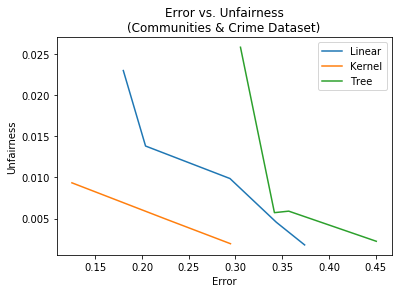

In [5]:
def multiple_classifiers_pareto(dataset, gamma_list=[0.002, 0.005, 0.01, 0.02, 0.05], save_results=False):

    ln_predictor = linear_model.LinearRegression()
    svm_predictor = svm.LinearSVR()
    tree_predictor = tree.DecisionTreeRegressor(max_depth=3)
    kernel_predictor = KernelRidge(alpha=1.0, gamma=1.0, kernel='rbf')
    predictor_dict = {'Linear': {'predictor': ln_predictor, 'iters': 200},
                      'Tree': {'predictor': tree_predictor, 'iters': 200},
                      'Kernel': {'predictor': kernel_predictor, 'iters': 200}}

    results_dict = {}

    for pred in predictor_dict:
        predictor = predictor_dict[pred]['predictor']
        max_iters = predictor_dict[pred]['iters']
        fair_clf = Model(C=100, printflag=False, gamma=1, predictor=predictor, max_iters=max_iters)
        fair_clf.set_options(max_iters=max_iters)
        errors, fp_violations, fn_violations = fair_clf.pareto(dataset, gamma_list)
        results_dict[pred] = {'errors': errors, 'fp_violations': fp_violations, 'fn_violations': fn_violations}
        plt.plot(errors, fp_violations, label=pred)

    if save_results:
        pickle.dump(results_dict, open('results_dict_' + str(gamma_list) + '_gammas' + str(gamma_list) + '.pkl', 'wb'))

    plt.xlabel('Error')
    plt.ylabel('Unfairness')
    plt.legend()
    plt.title('Error vs. Unfairness\n(Communities & Crime Dataset)')
    plt.show()
    
    
multiple_classifiers_pareto(data_set)

([0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.0086, 0.010750000000000001, 0.01435, 0.023000000000000003], [0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.03560000000000001, 0.030149999999999996, 0.011600000000000003])


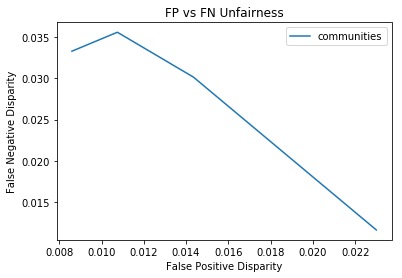

In [6]:

def fp_vs_fn(dataset, gamma_list):
    fp_auditor = Auditor(dataset, 'FP')
    fn_auditor = Auditor(dataset, 'FN')
    fp_violations = []
    fn_violations = []
    for g in gamma_list:
        C = 10
        print_flag = False 
        max_iterations = 200
        fair_def = 'FP'
        fair_model = Model(C=C, printflag=print_flag, gamma=g, fairness_def=fair_def,
             max_iters=max_iterations)
        fair_model.set_options(gamma=g)
        fair_model.fit(dataset)
        predictions = (fair_model.predict(dataset)).labels
        predictions_inv = tuple([abs(1 - p) for p in predictions])
        _, fp_diff = fp_auditor.audit(predictions)
        _, fn_diff = fn_auditor.audit(predictions_inv)
        fp_violations.append(fp_diff)
        fn_violations.append(fn_diff)

    print((fp_violations, fn_violations))

    plt.plot(fp_violations, fn_violations, label='communities')
    plt.xlabel('False Positive Disparity')
    plt.ylabel('False Negative Disparity')
    plt.legend()
    plt.title('FP vs FN Unfairness')
    plt.show()
    
gamma_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.02, 0.03]
fp_vs_fn(data_set, gamma_list)